En este primer apartado utilizaremos un dataset de Reddit (incluido en este entregador) para intentar clasificar el subreddit al que pertenece un comentario.

- Tarea 1: Preprocesar el dataset. Realiza los pasos necesarios para normalizar el dataset. Las etiquetas que nos interesan principalmente son las de "comment" y "subreddit".  No obstante, puedes utilizar el resto si deseas profundizar para conseguir un mejor resultado.

- Tarea 2: Utiliza y evalúa modelos para clasificar los textos en función de su subreddit. Para ello, deberás utilizar un conjunto de entrenamiento (80% de los datos) y otro de test (20% de los datos). Evalúa con la métrica "precision" el rendimiento de los modelos que pruebes. Deberás prestar atención a describir los métodos que uses para obtener características del texto y para clasificar. Como mínimo debéis utilizar dos procedimientos distintos, uno de ellos siendo de Machine Learning obligatoriamente.

# Clasificación de textos

## Tarea 1: Preprocesar el dataset

In [29]:
import pandas as pd

Cargamos el CSV original

In [30]:
file_path = "dataset_reddit.csv"
df = pd.read_csv(file_path, sep=",", encoding="utf-8")


Exploramos el dataset

In [31]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      8989 non-null   int64 
 1   label           8989 non-null   int64 
 2   comment         8975 non-null   object
 3   author          8989 non-null   object
 4   subreddit       8989 non-null   object
 5   score           8989 non-null   int64 
 6   ups             8989 non-null   int64 
 7   downs           8989 non-null   int64 
 8   date            8989 non-null   object
 9   created_utc     8989 non-null   object
 10  parent_comment  8989 non-null   object
dtypes: int64(5), object(6)
memory usage: 772.6+ KB
None
   Unnamed: 0  label                                            comment  \
0         235      0  best wall-music experience ever going see roge...   
1         257      0           tend agree you, puppeteers 'persuasive'.   
2         258      0                   

Visualizamos y analizamos los contenidos de las etiquetas "comment" y "subreddit"

In [77]:
df = df[["comment", "subreddit"]]
df_comment = df["comment"]
comments = [line for line in df_comment]


A simple vista, las siguientes tareas serán:
- Eliminar símbolos relacionados con el salto de línea, tabulaciones y otras similares. (\r)
- Conversión a minúsculas
- Eliminación de puntuaciones
- Eliminación de stopwords
- Eliminación de URLs y etiquetas HTML
- Eliminación de espacios extras/ contracciones

In [33]:
import string
import nltk
from nltk.corpus import stopwords
import contractions
import re
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
import spacy
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Limpieza y normalizacion de textos


In [34]:
# # Conversión a minúsculas
# def conv_minusculas(text):
#     '''
#     Convierte el texto en minúsculas.
#     '''
#     return text.lower()

# # Eliminación de puntuación
# def elim_punct(text):
#     '''
#     Elimina las puntuaciones.
#     '''
#     return text.translate(str.maketrans("","",string.punctuation))

# # Tokenización 
# def word_tok(text):
#     return nltk.word_tokenize(text)

# def sent_tok(text):
#     return nltk.sent_tokenize(text)

# # Eliminar stopwords
# def elim_stopwords(text):
#     return [word for word in text if word.lower() not in stopwords.words("english")]

# # Eliminación de espacios extras
# def elim_extra_space(text):
#     return " ".join(text.split())

# def elim_contract(text):
#     return contractions.fix(text)

# # Eliminación de URLs
# def elim_URL(text):
#     url_pattern = re.compile(r"http[s]?://\S+")
#     return re.sub(url_pattern,"", text)

# # Eliminación de etiquetas HTML
# def elim_HTML(text):
#     return BeautifulSoup(text, "html.parser").get_text()

In [35]:
def clean_text(texto, stemming=True):
    # Conversión a minúsculas
    texto = texto.lower()

    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans("","",string.punctuation))

    # Eliminar espacios extra
    texto = " ".join(texto.split())

    # Eliminar contracciones
    texto = contractions.fix(texto)

    # Eliminar URLs
    url_pattern = re.compile(r"http[s]?://\S+")
    texto = re.sub(url_pattern,"", texto)

    # Eliminar etiquetas HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()

    # Tokenización
    tokens = nltk.word_tokenize(texto, "english")

    # Eliminar stopwords
    stopwords_en = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stopwords_en]

    # Stemmming
    if stemming:
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
    # Lematización
    else:
        nlp = spacy.load("en_core_webs")
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]
    
    # Reconstruir texto limpio
    texto_limpio = " ".join(tokens)
    return texto_limpio


Aplicar la funciín a la columna comment


In [36]:
df["comment_clean"] = df["comment"].astype(str).apply(clean_text)
df.head(5)

,comment,subreddit,comment_clean
0,best wall-music experience ever going see roge...,Christianity,best wallmus experi ever go see roger water wall
1,"tend agree you, puppeteers 'persuasive'.",conspiracy,tend agre puppet persuas
2,zionist overlords say is.,uncensorednews,zionist overlord say
3,"seriously, like wwe...",worldpolitics,serious like wwe
4,nobody cares.... trump won.. go spam sub bs.,The_Donald,nobodi care trump go spam sub bs


In [37]:
df.isnull().sum()

comment          14
subreddit         0
comment_clean     0
dtype: int64

columna subreddit

Número de clases (subreddits) distintas: 612

Distribución por subreddit:
 subreddit
politics          2423
news               550
worldnews          365
askreddit          354
tumblrinaction     346
                  ... 
endlesswar           1
neworleans           1
geopolitics          1
exposureporn         1
objectivism          1
Name: count, Length: 612, dtype: int64

Valores nulos en 'subreddit': 0
Valores vacíos o solo espacios en 'subreddit': 0


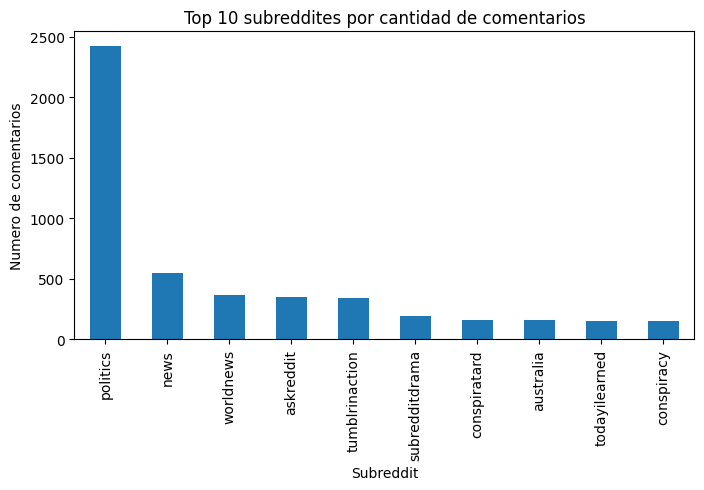

In [38]:
# Valores unicos y cantidad
df['subreddit'] = df['subreddit'].str.lower().str.strip()

categorias = df["subreddit"].value_counts()
print("Número de clases (subreddits) distintas:", len(categorias))
print("\nDistribución por subreddit:\n", categorias)

# Revisar valores nulos o vacíos
nulos = df["subreddit"].isnull().sum()
print("\nValores nulos en 'subreddit':", nulos)

vacios = (df["subreddit"].str.strip() == "").sum()
print("Valores vacíos o solo espacios en 'subreddit':", vacios)

# Visualizar graficamente la distribucion
import matplotlib.pyplot as plt

n = 10
categorias.head(n).plot(kind="bar", figsize=(8,4), title= f'Top {n} subreddites por cantidad de comentarios')
plt.xlabel("Subreddit")
plt.ylabel("Numero de comentarios")
plt.show()


Observamos que el dataset está muy desbalanceado. Esto puede causar un gran problema a la hora de entrenar al modelo. Una posible solución seria limitar la clasificación a los subreddits más frecuentes y agrupar el resto bajo la etiqueta "otros".

In [40]:
top_subs = categorias.index[:10]
df["top_subreddit"] = df["subreddit"].apply(lambda x: x if x in top_subs else "otros")
df["top_subreddit"].value_counts()

top_subreddit
otros             4124
politics          2423
news               550
worldnews          365
askreddit          354
tumblrinaction     346
subredditdrama     198
conspiratard       163
australia          159
todayilearned      155
conspiracy         152
Name: count, dtype: int64

In [61]:
# Generamos una columna con las clases de subreddit si su cantidad es mayor que 1, en otro caso lo agrupamos con la etiqueta "otros"
frec = df["subreddit"].value_counts()
subreddit_mas = frec[frec>1].index

df["subreddit_2"] = df["subreddit"].apply(lambda x: x if x in subreddit_mas else "otros")

Vectorizamos los textos para faciliatar el entrenamiento del modelo, ya que los modelos de Machine Learning no entienden palabras, entienden números. Para ello aplicamos un método más robusto que bag-of-words: TF-IDF 

- **``TF-IDF (Term Frequency-Inverse Document Frequency)``**: Es una mejora de BoW. **Pondera las palabras no solo por su frecuencia** en un documento (TF), sino **también por su rareza en todo el corpus (IDF)**. Las palabras que son comunes en un documento pero raras en otros reciben un peso mayor, haciéndolas más significativas.

**``TF-IDF = TF × IDF``**

Donde:
- TF = ``(frecuencia de palabra en documento) / (total palabras en documento)``
- IDF = ``log((total documentos) / (documentos que contienen la palabra))``

Usando solo el top 10 de subreddits

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Seleccionamos las variables
x = df["comment_clean"]
y = df["top_subreddit"]

# Dividimos el conjunto de datos en: 80% train y 20% test
# stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)



Usando todas las clases de subreddit

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# # Seleccionamos las variables
# x = df["comment_clean"]
# y = df["subreddit_2"]

# # Dividimos el conjunto de datos en: 80% train y 20% test
# # stratify = y: Garantiza que la proporción de clases (subreddits) se mantenga igual en train y test. Esto es crucial porque el dataset está desbalanceado.
# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=42)

# # Vectorización TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)



Comenzamos a entrenar los modelos

1. Modelo de Machine Learning

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, classification_report

# Entrenar el modelo
clf_nb = MultinomialNB()
clf_nb.fit(x_train_tfidf, y_train)

# Predecir
y_pred_nb = clf_nb.predict(x_test_tfidf)

# Evaluar precisión
print(classification_report(y_test, y_pred_nb, digits=3))
print("Precisión promedio:", precision_score(y_test, y_pred_nb, average='macro'))


                precision    recall  f1-score   support

     askreddit      0.000     0.000     0.000        71
     australia      0.000     0.000     0.000        32
    conspiracy      0.571     0.267     0.364        30
  conspiratard      0.000     0.000     0.000        32
          news      0.000     0.000     0.000       110
         otros      0.504     0.902     0.646       825
      politics      0.557     0.353     0.432       485
subredditdrama      0.000     0.000     0.000        40
 todayilearned      0.000     0.000     0.000        31
tumblrinaction      0.000     0.000     0.000        69
     worldnews      0.000     0.000     0.000        73

      accuracy                          0.513      1798
     macro avg      0.148     0.138     0.131      1798
  weighted avg      0.391     0.513     0.419      1798

Precisión promedio: 0.14837778119498482


c:\Users\niaib\OneDrive\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\niaib\OneDrive\3º Cuatrimestre\PLN\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, classification_report

# Definición del modelo LogReg con manejo de clases desbalanceadas
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Entrenamiento del modelo
clf_lr.fit(x_train_tfidf, y_train)

# Predicción en test
y_pred_lr = clf_lr.predict(x_test_tfidf)

# Evaluación del rendimiento con métricas de precisión (macro para balancear clases)
print("Reporte detallado de clasificación:\n", classification_report(y_test, y_pred_lr, digits=3))
print("Precisión promedio macro:", precision_score(y_test, y_pred_lr, average='macro'))


Reporte detallado de clasificación:
                 precision    recall  f1-score   support

     askreddit      0.059     0.141     0.083        71
     australia      0.099     0.438     0.161        32
    conspiracy      0.210     0.567     0.306        30
  conspiratard      0.043     0.156     0.067        32
          news      0.152     0.218     0.179       110
         otros      0.629     0.198     0.301       825
      politics      0.590     0.256     0.357       485
subredditdrama      0.053     0.250     0.088        40
 todayilearned      0.013     0.065     0.022        31
tumblrinaction      0.095     0.232     0.134        69
     worldnews      0.099     0.205     0.134        73

      accuracy                          0.222      1798
     macro avg      0.186     0.248     0.167      1798
  weighted avg      0.475     0.222     0.271      1798

Precisión promedio macro: 0.18566219034336082
